In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import sqlalchemy

C:\Users\Swati\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Swati\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Swati\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from sqlalchemy import create_engine
address ='crop-database.crsrmxqqzioy.us-east-2.rds.amazonaws.com'
port='5432'
username='swati_admin'
password='crop_damage19'
dbname='crop_damage'

postgres_str=('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
             .format(username=username,
                    password=password,
                    ipaddress=address,
                    port=port,
                    dbname=dbname))
cnx=create_engine(postgres_str)

In [3]:
df=pd.read_sql('''SELECT * FROM public.crop_damage_prediction;''',cnx)

In [4]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage  
0                  0       1            0  
1                  0       2            1  
2                  0       2            1  
3                  0       2            1  
4                  0       2            1

In [5]:
print(df.shape)

(88858, 10)


In [6]:
df.dtypes

id                          object
estimated_insects_count      int64
crop_type                    int64
soil_type                    int64
pesticide_use_category       int64
number_doses_week            int64
number_weeks_used          float64
number_weeks_quit            int64
season                       int64
crop_damage                  int64
dtype: object

In [7]:
df_original=df

In [8]:
ID_COL, TARGET_COL = 'id', 'crop_damage'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       88858 non-null  object 
 1   estimated_insects_count  88858 non-null  int64  
 2   crop_type                88858 non-null  int64  
 3   soil_type                88858 non-null  int64  
 4   pesticide_use_category   88858 non-null  int64  
 5   number_doses_week        88858 non-null  int64  
 6   number_weeks_used        79858 non-null  float64
 7   number_weeks_quit        88858 non-null  int64  
 8   season                   88858 non-null  int64  
 9   crop_damage              88858 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB


In [10]:
df.describe()

estimated_insects_count     crop_type     soil_type  \
count             88858.000000  88858.000000  88858.000000   
mean               1399.012210      0.284375      0.458417   
std                 849.048781      0.451119      0.498271   
min                 150.000000      0.000000      0.000000   
25%                 731.000000      0.000000      0.000000   
50%                1212.000000      0.000000      0.000000   
75%                1898.000000      1.000000      1.000000   
max                4097.000000      1.000000      1.000000   

       pesticide_use_category  number_doses_week  number_weeks_used  \
count            88858.000000       88858.000000       79858.000000   
mean                 2.264186          25.849952          28.623970   
std                  0.461772          15.554428          12.391881   
min                  1.000000           0.000000           0.000000   
25%                  2.000000          15.000000          20.000000   
50%                  2.000000          20.000000          28.000000   
75%                  3.000000          40.000000          37.000000   
max                  3.000000          95.000000          67.000000   

       number_weeks_quit        season   crop_damage  
count       88858.000000  88858.000000  88858.000000  
mean            9.589986      1.896959      0.190562  
std             9.900631      0.701322      0.454215  
min             0.000000      1.000000      0.000000  
25%             0.000000      1.000000      0.000000  
50%             7.000000      2.000000      0.000000  
75%            16.000000      2.000000      0.000000  
max            50.000000      3.000000      2.000000

### Null Values

In [11]:
null_values_per_variable = 100 * (df.isnull().sum()/df.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

number_weeks_used          10.1
crop_damage                 0.0
season                      0.0
number_weeks_quit           0.0
number_doses_week           0.0
pesticide_use_category      0.0
soil_type                   0.0
crop_type                   0.0
estimated_insects_count     0.0
id                          0.0
dtype: float64

In [12]:
df.crop_damage.value_counts()

0    74238
1    12307
2     2313
Name: crop_damage, dtype: int64

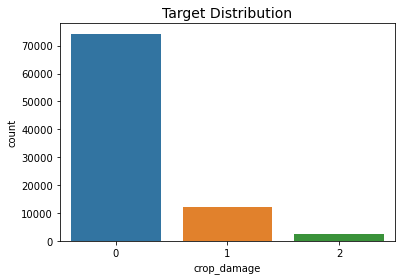

In [13]:
_ = sns.countplot(df[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

## Hypothesis:
### 1. Pesticides are destroying crop more?
### 2. More the number of insects count more damage?
### 3. Crop type and soil type may matter?
### 4. More the number of doses in a week more the damage?

In [14]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]

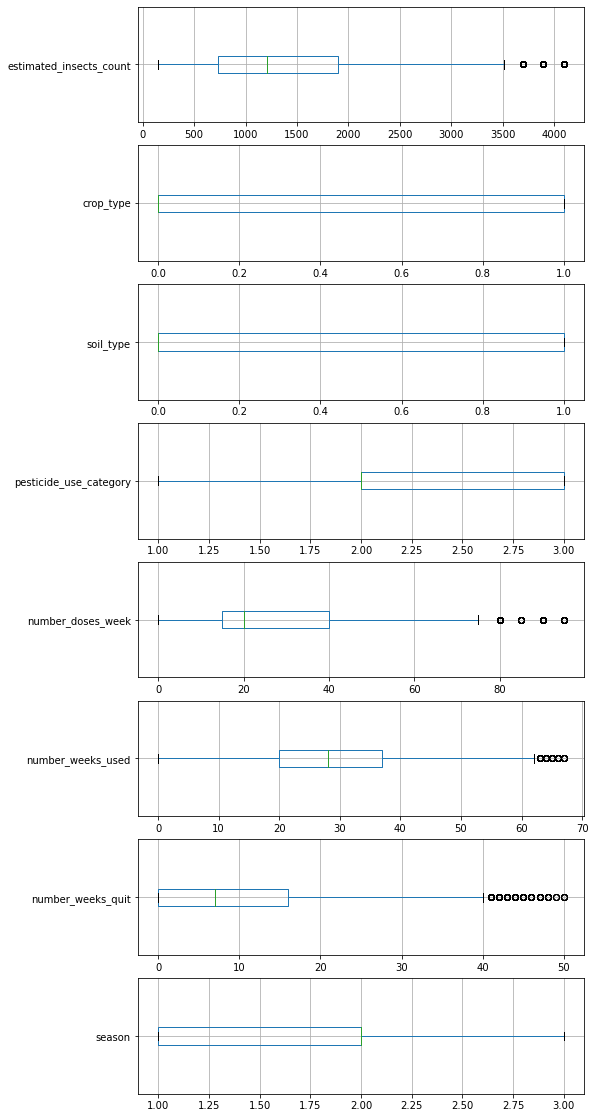

In [15]:
fig, axes = plt.subplots(8, 1, figsize=(8, 20))
for i, c in enumerate(features):
  _ = df[[c]].boxplot(ax=axes[i], vert=False)

### Checking for pesticides

In [16]:
df['pesticide_use_category'].value_counts()

2    63709
3    24312
1      837
Name: pesticide_use_category, dtype: int64

In [17]:
a=df[df['crop_damage']==0]['pesticide_use_category'].value_counts()
b=df[df['crop_damage']==1]['pesticide_use_category'].value_counts()
c=df[df['crop_damage']==2]['pesticide_use_category'].value_counts()

Text(0.5, 1.0, 'Crop Damage : 2')

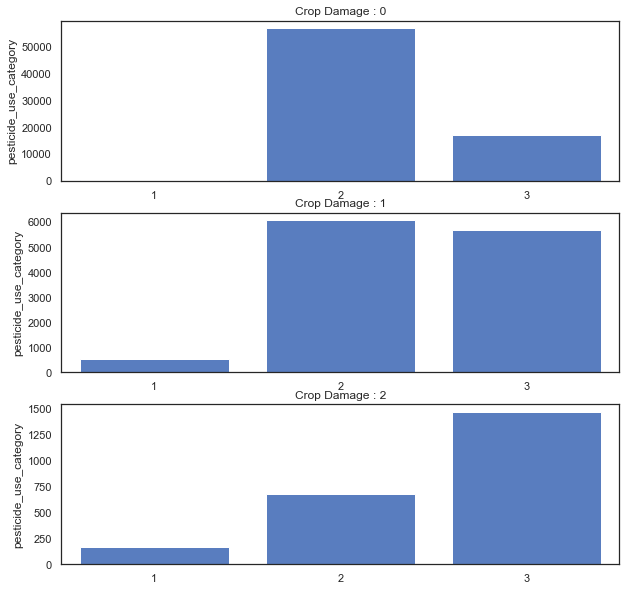

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

### 1.It is clear that using type 3 pesticides have given more damage to crop.
### 2.It is observed that type 2 pesticides is not the major reason for crop damage due to pesticides.

## Crop Type

In [19]:
a=df[df['crop_damage']==0]['crop_type'].value_counts()
b=df[df['crop_damage']==1]['crop_type'].value_counts()
c=df[df['crop_damage']==2]['crop_type'].value_counts()

Text(0.5, 1.0, 'Crop Damage : 2')

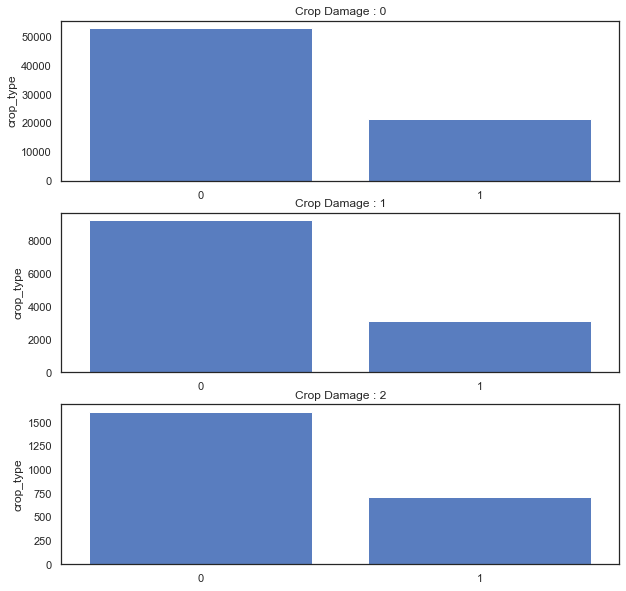

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

In [21]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000,3500,4000,4500]
df['estimated_insects_count_binned'] = pd.cut(df['estimated_insects_count'], bins)

In [22]:
a=df[df['crop_damage']==0]['estimated_insects_count_binned'].value_counts()
b=df[df['crop_damage']==1]['estimated_insects_count_binned'].value_counts()
c=df[df['crop_damage']==2]['estimated_insects_count_binned'].value_counts()

Text(0.5, 1.0, 'Crop Damage : 2')

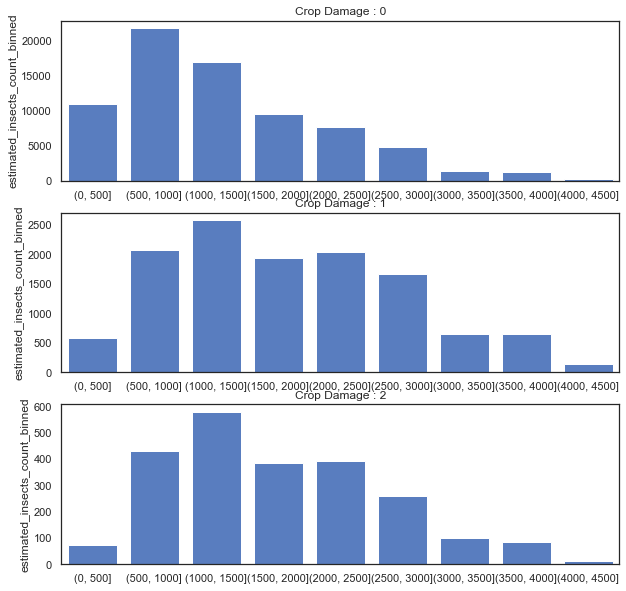

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

### We can conclude that it's not high number of insects means more crop damage.

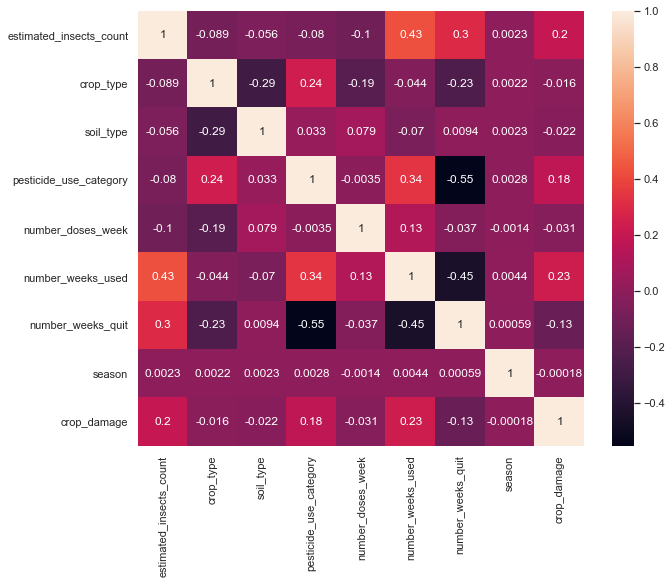

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(),annot=True,ax=ax)

In [25]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage estimated_insects_count_binned  
0                  0       1            0                       (0, 500]  
1                  0       2            1                       (0, 500]  
2                  0       2            1                       (0, 500]  
3                  0       2            1                       (0, 500]  
4                  0       2            1                       (0, 500]

## Soil Type

In [26]:
a=df[df['crop_damage']==0]['soil_type'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['soil_type'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['soil_type'].value_counts(normalize=True)

Text(0.5, 1.0, 'Crop Damage : 2')

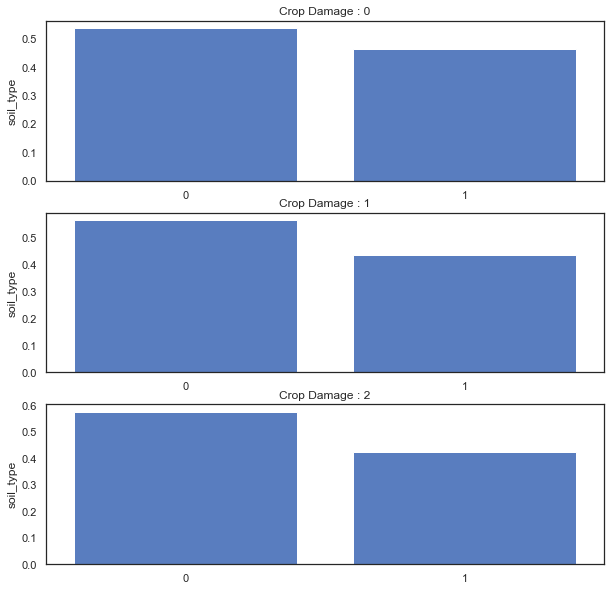

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2')

In [28]:
a=df[df['crop_damage']==0]['number_doses_week'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['number_doses_week'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['number_doses_week'].value_counts(normalize=True)

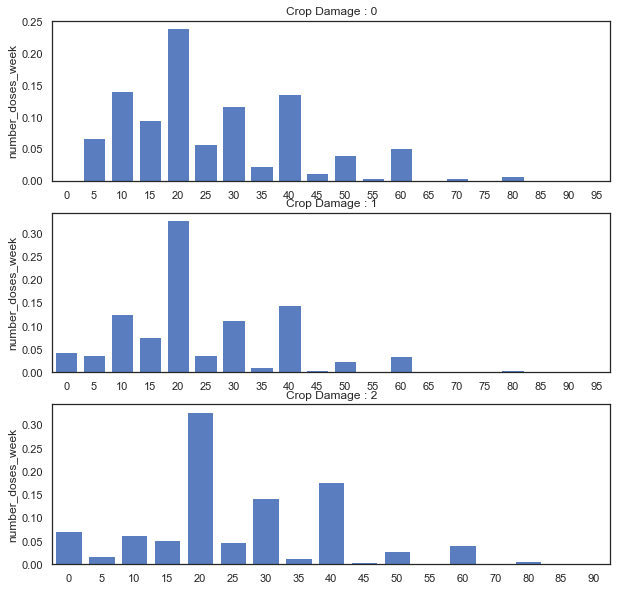

In [29]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

### It is observed more number of doses doesn't lead to more crop damage

# Number of weeks used

In [30]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage estimated_insects_count_binned  
0                  0       1            0                       (0, 500]  
1                  0       2            1                       (0, 500]  
2                  0       2            1                       (0, 500]  
3                  0       2            1                       (0, 500]  
4                  0       2            1                       (0, 500]

In [31]:
df['number_weeks_used'].max()

67.0

In [32]:
bins = [0, 10, 20, 30, 40, 50, 60,70]
df['number_weeks_used_binned'] = pd.cut(df['number_weeks_used'], bins)

In [33]:
a=df[df['crop_damage']==0]['number_weeks_used_binned'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['number_weeks_used_binned'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['number_weeks_used_binned'].value_counts(normalize=True)

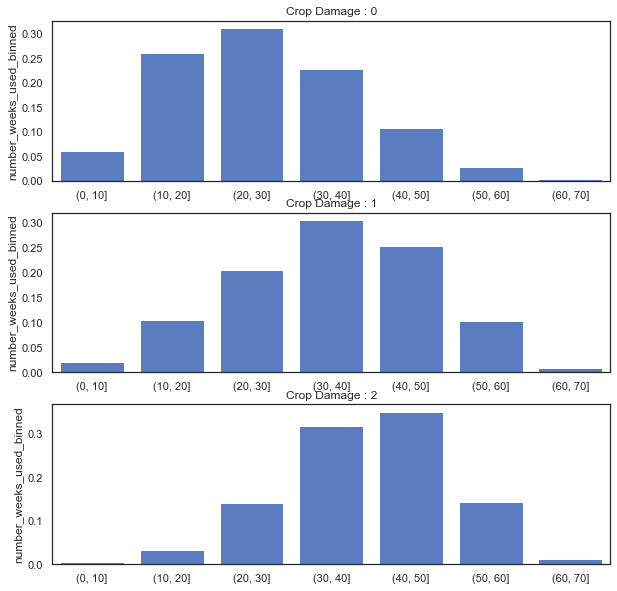

In [34]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

## It can be concluded that for higher number of weeks used have more crop damage due to pesticides

# Number of weeks quit

In [35]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage estimated_insects_count_binned  \
0                  0       1            0                       (0, 500]   
1                  0       2            1                       (0, 500]   
2                  0       2            1                       (0, 500]   
3                  0       2            1                       (0, 500]   
4                  0       2            1                       (0, 500]   

  number_weeks_used_binned  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN

In [36]:
df['number_weeks_quit'].max()

50

In [37]:
bins = [0, 10, 20, 30, 40, 50, 60]
df['number_weeks_quit_binned'] = pd.cut(df['number_weeks_quit'], bins)

In [38]:
a=df[df['crop_damage']==0]['number_weeks_quit_binned'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['number_weeks_quit_binned'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['number_weeks_quit_binned'].value_counts(normalize=True)

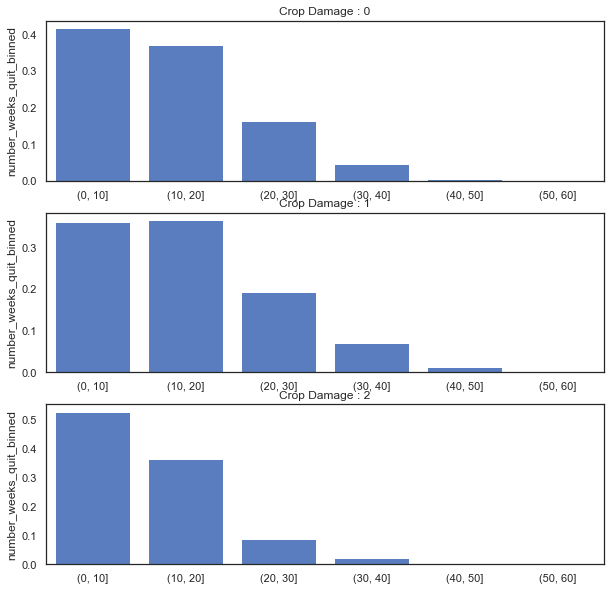

In [39]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

# Season

In [40]:
a=df[df['crop_damage']==0]['season'].value_counts(normalize=True)
b=df[df['crop_damage']==1]['season'].value_counts(normalize=True)
c=df[df['crop_damage']==2]['season'].value_counts(normalize=True)

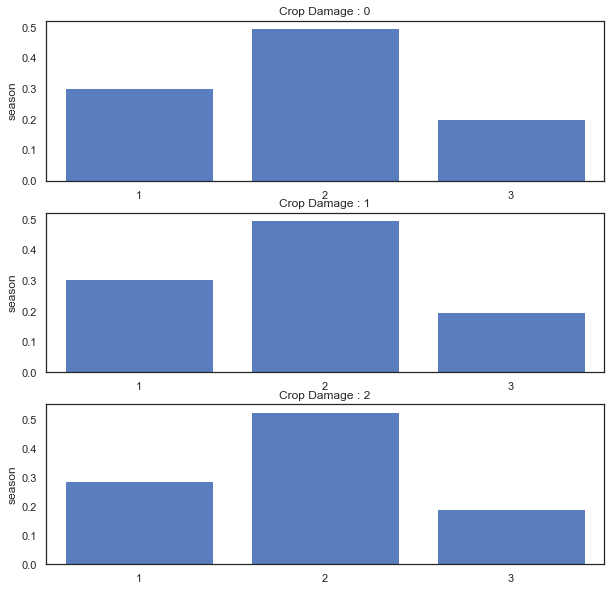

In [41]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop Damage : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop Damage : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Crop Damage : 2');

In [42]:
df[df['number_doses_week']==0]['pesticide_use_category'].value_counts()

1    837
Name: pesticide_use_category, dtype: int64

In [43]:
df['number_doses_week'].value_counts()

20    22589
40    12298
10    12111
30    10438
15     8178
5      5520
25     4890
60     4367
50     3361
35     1832
45      936
0       837
80      672
70      303
55      277
90       83
65       64
75       61
95       30
85       11
Name: number_doses_week, dtype: int64

In [44]:
df[df['number_weeks_used']==0]['pesticide_use_category'].value_counts()

1    740
Name: pesticide_use_category, dtype: int64

In [45]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000,3500,4000,4500]
df['estimated_insects_count_binned'] = pd.cut(df['estimated_insects_count'], bins)

In [46]:
a=df[df['pesticide_use_category']==1]['crop_type'].value_counts(normalize=True)
b=df[df['pesticide_use_category']==2]['crop_type'].value_counts(normalize=True)
c=df[df['pesticide_use_category']==3]['crop_type'].value_counts(normalize=True)

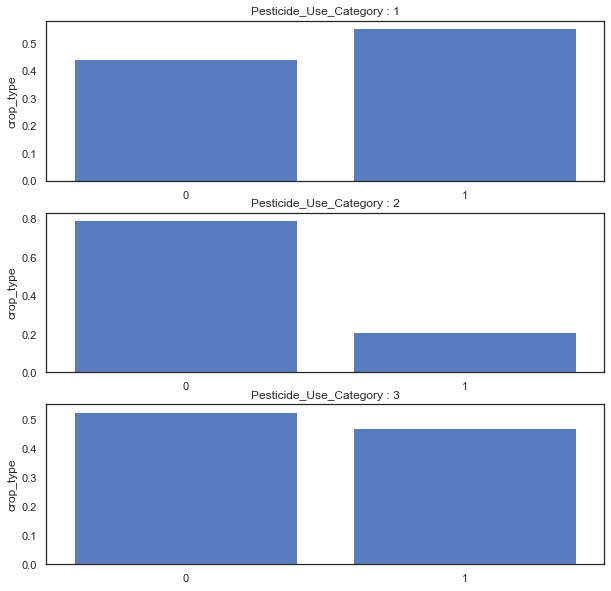

In [47]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Pesticide_Use_Category : 1')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Pesticide_Use_Category : 2')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Pesticide_Use_Category : 3');

### Looks like crop type 1 doesn't use much of pesticides as compare to crop type 0

In [48]:
a=df[df['crop_type']==0]['estimated_insects_count_binned'].value_counts(normalize=True)
b=df[df['crop_type']==1]['estimated_insects_count_binned'].value_counts(normalize=True)

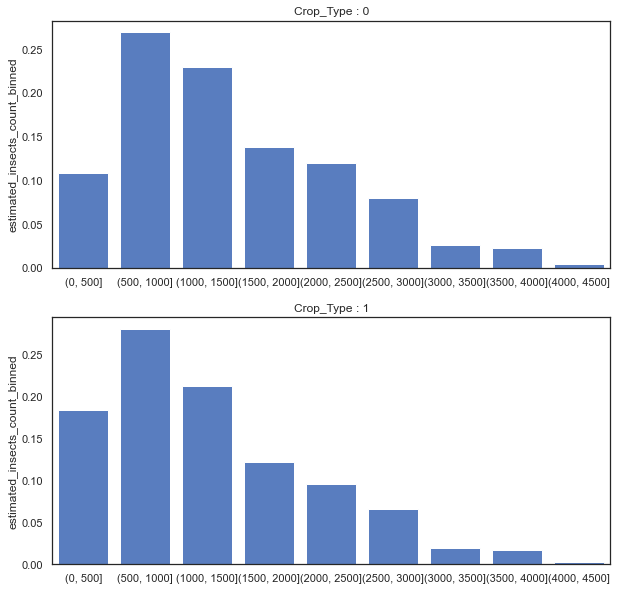

In [49]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Crop_Type : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Crop_Type : 1');

### Seems like both type of crops have equal amount of insects

In [50]:
a=df[df['pesticide_use_category']==1]['soil_type'].value_counts(normalize=True)
b=df[df['pesticide_use_category']==2]['soil_type'].value_counts(normalize=True)
c=df[df['pesticide_use_category']==3]['soil_type'].value_counts(normalize=True)

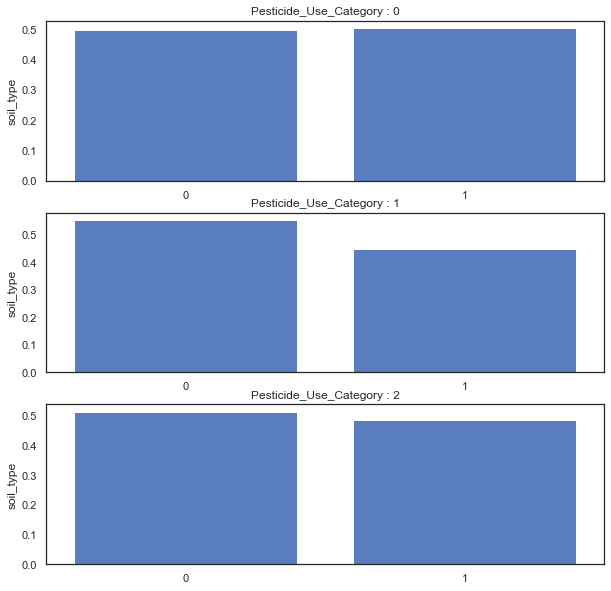

In [51]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(3, 1, figsize=(10, 10))
sns.barplot(a.index,a,  color="b", ax=axes[0]).set_title('Pesticide_Use_Category : 0')
sns.barplot(b.index,b,  color="b", ax=axes[1]).set_title('Pesticide_Use_Category : 1')
sns.barplot(c.index,c,  color="b", ax=axes[2]).set_title('Pesticide_Use_Category : 2');

### Looks like for soil type 1 pesticides used previously are used as compare to never and current pesticides

# Feature Engineering

In [52]:
df=pd.read_sql('''SELECT * FROM public.crop_damage_prediction;''',cnx)

In [53]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage  
0                  0       1            0  
1                  0       2            1  
2                  0       2            1  
3                  0       2            1  
4                  0       2            1

In [54]:
df['Avg_Dose_Insect'] = df['estimated_insects_count']/df['number_doses_week']

In [55]:
df.isnull().sum()

id                            0
estimated_insects_count       0
crop_type                     0
soil_type                     0
pesticide_use_category        0
number_doses_week             0
number_weeks_used          9000
number_weeks_quit             0
season                        0
crop_damage                   0
Avg_Dose_Insect               0
dtype: int64

In [56]:
print("Mean of Number_Weeks_Used before replacement is:",df['number_weeks_used'].mean())
print("Median of Number_Weeks_Used before replacement is:",df['number_weeks_used'].median())

Mean of Number_Weeks_Used before replacement is: 28.62397004683313
Median of Number_Weeks_Used before replacement is: 28.0


In [57]:
df['number_weeks_used'].fillna((df['number_weeks_used'].mean()), inplace=True)
df.isnull().sum().sum()

0

In [58]:
print("Mean of Number_Weeks_Used after replacement is:",df['number_weeks_used'].mean())
print("Median of Number_Weeks_Used after replacement is:",df['number_weeks_used'].median())

Mean of Number_Weeks_Used after replacement is: 28.623970046831996
Median of Number_Weeks_Used after replacement is: 28.62397004683313


In [59]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage  Avg_Dose_Insect  
0                  0       1            0              inf  
1                  0       2            1              inf  
2                  0       2            1              inf  
3                  0       2            1              inf  
4                  0       2            1              inf

In [60]:
df['TotalDoses'] = df['number_doses_week'] * df['number_weeks_used']

In [61]:
df.pesticide_use_category.value_counts()

2    63709
3    24312
1      837
Name: pesticide_use_category, dtype: int64

In [62]:
df.head()

id  estimated_insects_count  crop_type  soil_type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   pesticide_use_category  number_doses_week  number_weeks_used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   number_weeks_quit  season  crop_damage  Avg_Dose_Insect  TotalDoses  
0                  0       1            0              inf         0.0  
1                  0       2            1              inf         0.0  
2                  0       2            1              inf         0.0  
3                  0       2            1              inf         0.0  
4                  0       2            1              inf         0.0

In [63]:
df.isnull().sum()

id                         0
estimated_insects_count    0
crop_type                  0
soil_type                  0
pesticide_use_category     0
number_doses_week          0
number_weeks_used          0
number_weeks_quit          0
season                     0
crop_damage                0
Avg_Dose_Insect            0
TotalDoses                 0
dtype: int64

In [64]:
df['Avg_Dose_Insect'].value_counts()

73.900000    856
60.600000    845
inf          837
69.250000    825
83.900000    814
            ... 
12.153846      1
3.212500       1
17.293333      1
2.844444       1
2.900000       1
Name: Avg_Dose_Insect, Length: 1029, dtype: int64

In [65]:
df['Avg_Dose_Insect'].replace(to_replace =np.inf,  
                            value =0,inplace=True)

In [66]:
df.drop(['id'],axis=1,inplace=True)

# Machine Learning Modelling

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

C:\Users\Swati\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [68]:
X=df.loc[:,df.columns != 'crop_damage']
Y=df.crop_damage

In [69]:
skf=StratifiedKFold(n_splits=5,random_state=None)
#skf.get_n_splits(t,val)
for train_index,test_index in skf.split(X,Y):
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=Y.iloc[train_index],Y.iloc[test_index]

In [70]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [71]:
from sklearn.model_selection import train_test_split
X_train_smote, y_train_smote = smote.fit_sample(X_train.astype('float'),y_train)

### Logistic Regression

In [72]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

clf = LogisticRegression()
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.6079005120702268

col_0           0     1     2
crop_damage                  
0            9879  2188  2780
1            723   622   1117
2            99    61    302

0.4039186287947507
0.5239022435044114


### Decision Tree

In [73]:
clf = DecisionTreeClassifier(random_state = 1)
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.7455967587642789

col_0            0     1    2
crop_damage                  
0            12510  1959  378
1            1615   693   154
2            263    152   47

0.3992653112584763
0.4086015126819799


### Random Forest

In [74]:
clf = RandomForestClassifier()
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.8100838444657026

col_0            0    1    2
crop_damage                 
0            13792  905  150
1            1772   571  119
2            288    141  33

0.4441475113549178
0.41076523640692786


### LGBMClassifier

In [79]:
clf_lgbm = LGBMClassifier(n_estimators = 1000,
                    learning_rate = 0.05,
                    colsample_bytree = 0.76,
                    )
_ = clf_lgbm.fit(X_train_smote, y_train_smote)

preds_val1 = clf_lgbm.predict(X_test)

accuracy_score(y_test,preds_val1)
pd.crosstab(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0.8382758426650161

col_0            0    1    2
crop_damage                 
0            14367  428  52 
1            1855   502  105
2            281    153  28

0.4951491926528951
0.41072518863484686


### CatBoostClassifier

In [76]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )
_ = clf.fit(X_train_smote, y_train_smote)

preds_val1 = clf.predict(X_test)

accuracy_score(y_test,preds_val1)
print(precision_score(y_test, preds_val1, average="macro"))
print(recall_score(y_test, preds_val1, average="macro"))

0:	learn: 1.0939052	total: 102ms	remaining: 5m 5s
1:	learn: 1.0885393	total: 159ms	remaining: 3m 58s
2:	learn: 1.0841276	total: 209ms	remaining: 3m 28s
3:	learn: 1.0790520	total: 256ms	remaining: 3m 11s
4:	learn: 1.0746930	total: 306ms	remaining: 3m 3s
5:	learn: 1.0701069	total: 359ms	remaining: 2m 59s
6:	learn: 1.0652099	total: 408ms	remaining: 2m 54s
7:	learn: 1.0607199	total: 462ms	remaining: 2m 52s
8:	learn: 1.0563733	total: 514ms	remaining: 2m 50s
9:	learn: 1.0521246	total: 569ms	remaining: 2m 50s
10:	learn: 1.0477841	total: 622ms	remaining: 2m 49s
11:	learn: 1.0440179	total: 672ms	remaining: 2m 47s
12:	learn: 1.0395207	total: 723ms	remaining: 2m 46s
13:	learn: 1.0355149	total: 780ms	remaining: 2m 46s
14:	learn: 1.0315648	total: 831ms	remaining: 2m 45s
15:	learn: 1.0278237	total: 886ms	remaining: 2m 45s
16:	learn: 1.0235346	total: 951ms	remaining: 2m 46s
17:	learn: 1.0196865	total: 1.01s	remaining: 2m 47s
18:	learn: 1.0161646	total: 1.06s	remaining: 2m 45s
19:	learn: 1.0125183	tot

160:	learn: 0.7663745	total: 8.52s	remaining: 2m 30s
161:	learn: 0.7655693	total: 8.57s	remaining: 2m 30s
162:	learn: 0.7647561	total: 8.63s	remaining: 2m 30s
163:	learn: 0.7635987	total: 8.68s	remaining: 2m 30s
164:	learn: 0.7624850	total: 8.74s	remaining: 2m 30s
165:	learn: 0.7616903	total: 8.79s	remaining: 2m 30s
166:	learn: 0.7610033	total: 8.84s	remaining: 2m 30s
167:	learn: 0.7603625	total: 8.89s	remaining: 2m 29s
168:	learn: 0.7592771	total: 8.94s	remaining: 2m 29s
169:	learn: 0.7584368	total: 9s	remaining: 2m 29s
170:	learn: 0.7577175	total: 9.05s	remaining: 2m 29s
171:	learn: 0.7568243	total: 9.1s	remaining: 2m 29s
172:	learn: 0.7557247	total: 9.15s	remaining: 2m 29s
173:	learn: 0.7549583	total: 9.2s	remaining: 2m 29s
174:	learn: 0.7540862	total: 9.25s	remaining: 2m 29s
175:	learn: 0.7533373	total: 9.3s	remaining: 2m 29s
176:	learn: 0.7524360	total: 9.35s	remaining: 2m 29s
177:	learn: 0.7514385	total: 9.4s	remaining: 2m 29s
178:	learn: 0.7506921	total: 9.45s	remaining: 2m 28s


318:	learn: 0.6764723	total: 16.8s	remaining: 2m 21s
319:	learn: 0.6761469	total: 16.9s	remaining: 2m 21s
320:	learn: 0.6759948	total: 16.9s	remaining: 2m 21s
321:	learn: 0.6757672	total: 17s	remaining: 2m 21s
322:	learn: 0.6755312	total: 17s	remaining: 2m 21s
323:	learn: 0.6750259	total: 17.1s	remaining: 2m 21s
324:	learn: 0.6747097	total: 17.2s	remaining: 2m 21s
325:	learn: 0.6742201	total: 17.2s	remaining: 2m 21s
326:	learn: 0.6739217	total: 17.3s	remaining: 2m 21s
327:	learn: 0.6737188	total: 17.3s	remaining: 2m 20s
328:	learn: 0.6733359	total: 17.3s	remaining: 2m 20s
329:	learn: 0.6730531	total: 17.4s	remaining: 2m 20s
330:	learn: 0.6728376	total: 17.4s	remaining: 2m 20s
331:	learn: 0.6728376	total: 17.5s	remaining: 2m 20s
332:	learn: 0.6723945	total: 17.5s	remaining: 2m 20s
333:	learn: 0.6721416	total: 17.6s	remaining: 2m 20s
334:	learn: 0.6719043	total: 17.6s	remaining: 2m 20s
335:	learn: 0.6716070	total: 17.7s	remaining: 2m 20s
336:	learn: 0.6713159	total: 17.7s	remaining: 2m 2

475:	learn: 0.6394022	total: 25.7s	remaining: 2m 16s
476:	learn: 0.6392895	total: 25.8s	remaining: 2m 16s
477:	learn: 0.6391328	total: 25.9s	remaining: 2m 16s
478:	learn: 0.6389667	total: 25.9s	remaining: 2m 16s
479:	learn: 0.6388012	total: 26s	remaining: 2m 16s
480:	learn: 0.6387056	total: 26.1s	remaining: 2m 16s
481:	learn: 0.6385557	total: 26.1s	remaining: 2m 16s
482:	learn: 0.6383057	total: 26.2s	remaining: 2m 16s
483:	learn: 0.6380203	total: 26.3s	remaining: 2m 16s
484:	learn: 0.6379359	total: 26.3s	remaining: 2m 16s
485:	learn: 0.6378301	total: 26.4s	remaining: 2m 16s
486:	learn: 0.6374658	total: 26.5s	remaining: 2m 16s
487:	learn: 0.6372221	total: 26.5s	remaining: 2m 16s
488:	learn: 0.6369772	total: 26.6s	remaining: 2m 16s
489:	learn: 0.6367028	total: 26.7s	remaining: 2m 16s
490:	learn: 0.6365535	total: 26.7s	remaining: 2m 16s
491:	learn: 0.6364543	total: 26.8s	remaining: 2m 16s
492:	learn: 0.6361996	total: 26.9s	remaining: 2m 16s
493:	learn: 0.6360383	total: 26.9s	remaining: 2m

631:	learn: 0.6179706	total: 35.8s	remaining: 2m 14s
632:	learn: 0.6179182	total: 35.9s	remaining: 2m 14s
633:	learn: 0.6178309	total: 35.9s	remaining: 2m 13s
634:	learn: 0.6177143	total: 35.9s	remaining: 2m 13s
635:	learn: 0.6176047	total: 36s	remaining: 2m 13s
636:	learn: 0.6174754	total: 36s	remaining: 2m 13s
637:	learn: 0.6173601	total: 36.1s	remaining: 2m 13s
638:	learn: 0.6172281	total: 36.1s	remaining: 2m 13s
639:	learn: 0.6171401	total: 36.2s	remaining: 2m 13s
640:	learn: 0.6170074	total: 36.3s	remaining: 2m 13s
641:	learn: 0.6169346	total: 36.3s	remaining: 2m 13s
642:	learn: 0.6168359	total: 36.4s	remaining: 2m 13s
643:	learn: 0.6166878	total: 36.4s	remaining: 2m 13s
644:	learn: 0.6166281	total: 36.5s	remaining: 2m 13s
645:	learn: 0.6165310	total: 36.5s	remaining: 2m 13s
646:	learn: 0.6164170	total: 36.6s	remaining: 2m 13s
647:	learn: 0.6163497	total: 36.7s	remaining: 2m 13s
648:	learn: 0.6162449	total: 36.7s	remaining: 2m 12s
649:	learn: 0.6161345	total: 36.8s	remaining: 2m 1

788:	learn: 0.6045113	total: 44.7s	remaining: 2m 5s
789:	learn: 0.6044766	total: 44.8s	remaining: 2m 5s
790:	learn: 0.6044356	total: 44.8s	remaining: 2m 5s
791:	learn: 0.6043679	total: 44.9s	remaining: 2m 5s
792:	learn: 0.6043078	total: 45s	remaining: 2m 5s
793:	learn: 0.6043078	total: 45s	remaining: 2m 4s
794:	learn: 0.6042186	total: 45.1s	remaining: 2m 4s
795:	learn: 0.6041930	total: 45.1s	remaining: 2m 4s
796:	learn: 0.6041519	total: 45.2s	remaining: 2m 4s
797:	learn: 0.6040866	total: 45.3s	remaining: 2m 4s
798:	learn: 0.6040056	total: 45.3s	remaining: 2m 4s
799:	learn: 0.6039606	total: 45.4s	remaining: 2m 4s
800:	learn: 0.6038746	total: 45.5s	remaining: 2m 4s
801:	learn: 0.6038279	total: 45.5s	remaining: 2m 4s
802:	learn: 0.6037513	total: 45.6s	remaining: 2m 4s
803:	learn: 0.6037103	total: 45.7s	remaining: 2m 4s
804:	learn: 0.6036734	total: 45.8s	remaining: 2m 4s
805:	learn: 0.6036098	total: 45.8s	remaining: 2m 4s
806:	learn: 0.6035149	total: 45.9s	remaining: 2m 4s
807:	learn: 0.60

949:	learn: 0.5937238	total: 55.1s	remaining: 1m 58s
950:	learn: 0.5936390	total: 55.1s	remaining: 1m 58s
951:	learn: 0.5935311	total: 55.2s	remaining: 1m 58s
952:	learn: 0.5934517	total: 55.2s	remaining: 1m 58s
953:	learn: 0.5933846	total: 55.3s	remaining: 1m 58s
954:	learn: 0.5932557	total: 55.4s	remaining: 1m 58s
955:	learn: 0.5931979	total: 55.4s	remaining: 1m 58s
956:	learn: 0.5931401	total: 55.5s	remaining: 1m 58s
957:	learn: 0.5930593	total: 55.6s	remaining: 1m 58s
958:	learn: 0.5929888	total: 55.6s	remaining: 1m 58s
959:	learn: 0.5929131	total: 55.7s	remaining: 1m 58s
960:	learn: 0.5928285	total: 55.7s	remaining: 1m 58s
961:	learn: 0.5927731	total: 55.8s	remaining: 1m 58s
962:	learn: 0.5927233	total: 55.9s	remaining: 1m 58s
963:	learn: 0.5926469	total: 55.9s	remaining: 1m 58s
964:	learn: 0.5925834	total: 56s	remaining: 1m 58s
965:	learn: 0.5925151	total: 56s	remaining: 1m 57s
966:	learn: 0.5924608	total: 56.1s	remaining: 1m 57s
967:	learn: 0.5923532	total: 56.2s	remaining: 1m 5

1104:	learn: 0.5846641	total: 1m 5s	remaining: 1m 51s
1105:	learn: 0.5846173	total: 1m 5s	remaining: 1m 51s
1106:	learn: 0.5845957	total: 1m 5s	remaining: 1m 51s
1107:	learn: 0.5845370	total: 1m 5s	remaining: 1m 51s
1108:	learn: 0.5844606	total: 1m 5s	remaining: 1m 51s
1109:	learn: 0.5844165	total: 1m 5s	remaining: 1m 51s
1110:	learn: 0.5843816	total: 1m 5s	remaining: 1m 51s
1111:	learn: 0.5843636	total: 1m 5s	remaining: 1m 51s
1112:	learn: 0.5843145	total: 1m 5s	remaining: 1m 51s
1113:	learn: 0.5842786	total: 1m 5s	remaining: 1m 50s
1114:	learn: 0.5841992	total: 1m 5s	remaining: 1m 50s
1115:	learn: 0.5841579	total: 1m 5s	remaining: 1m 50s
1116:	learn: 0.5841216	total: 1m 5s	remaining: 1m 50s
1117:	learn: 0.5840660	total: 1m 5s	remaining: 1m 50s
1118:	learn: 0.5840129	total: 1m 5s	remaining: 1m 50s
1119:	learn: 0.5839536	total: 1m 5s	remaining: 1m 50s
1120:	learn: 0.5839142	total: 1m 5s	remaining: 1m 50s
1121:	learn: 0.5838566	total: 1m 5s	remaining: 1m 50s
1122:	learn: 0.5837932	total

1256:	learn: 0.5766625	total: 1m 13s	remaining: 1m 41s
1257:	learn: 0.5765951	total: 1m 13s	remaining: 1m 41s
1258:	learn: 0.5765668	total: 1m 13s	remaining: 1m 41s
1259:	learn: 0.5765123	total: 1m 13s	remaining: 1m 41s
1260:	learn: 0.5764464	total: 1m 13s	remaining: 1m 41s
1261:	learn: 0.5763661	total: 1m 13s	remaining: 1m 41s
1262:	learn: 0.5763373	total: 1m 13s	remaining: 1m 41s
1263:	learn: 0.5762890	total: 1m 13s	remaining: 1m 40s
1264:	learn: 0.5762501	total: 1m 13s	remaining: 1m 40s
1265:	learn: 0.5762161	total: 1m 13s	remaining: 1m 40s
1266:	learn: 0.5761884	total: 1m 13s	remaining: 1m 40s
1267:	learn: 0.5761286	total: 1m 13s	remaining: 1m 40s
1268:	learn: 0.5760978	total: 1m 13s	remaining: 1m 40s
1269:	learn: 0.5760592	total: 1m 13s	remaining: 1m 40s
1270:	learn: 0.5760048	total: 1m 13s	remaining: 1m 40s
1271:	learn: 0.5759586	total: 1m 13s	remaining: 1m 40s
1272:	learn: 0.5759306	total: 1m 14s	remaining: 1m 40s
1273:	learn: 0.5758760	total: 1m 14s	remaining: 1m 40s
1274:	lear

1405:	learn: 0.5695238	total: 1m 21s	remaining: 1m 32s
1406:	learn: 0.5695026	total: 1m 21s	remaining: 1m 32s
1407:	learn: 0.5694316	total: 1m 21s	remaining: 1m 32s
1408:	learn: 0.5693551	total: 1m 22s	remaining: 1m 32s
1409:	learn: 0.5693253	total: 1m 22s	remaining: 1m 32s
1410:	learn: 0.5692809	total: 1m 22s	remaining: 1m 32s
1411:	learn: 0.5692485	total: 1m 22s	remaining: 1m 32s
1412:	learn: 0.5692111	total: 1m 22s	remaining: 1m 32s
1413:	learn: 0.5691637	total: 1m 22s	remaining: 1m 32s
1414:	learn: 0.5691324	total: 1m 22s	remaining: 1m 32s
1415:	learn: 0.5690800	total: 1m 22s	remaining: 1m 32s
1416:	learn: 0.5690366	total: 1m 22s	remaining: 1m 32s
1417:	learn: 0.5690062	total: 1m 22s	remaining: 1m 32s
1418:	learn: 0.5689504	total: 1m 22s	remaining: 1m 32s
1419:	learn: 0.5689011	total: 1m 22s	remaining: 1m 31s
1420:	learn: 0.5688436	total: 1m 22s	remaining: 1m 31s
1421:	learn: 0.5687740	total: 1m 22s	remaining: 1m 31s
1422:	learn: 0.5687735	total: 1m 22s	remaining: 1m 31s
1423:	lear

1557:	learn: 0.5627460	total: 1m 29s	remaining: 1m 23s
1558:	learn: 0.5627031	total: 1m 29s	remaining: 1m 23s
1559:	learn: 0.5626538	total: 1m 29s	remaining: 1m 23s
1560:	learn: 0.5626210	total: 1m 30s	remaining: 1m 22s
1561:	learn: 0.5625815	total: 1m 30s	remaining: 1m 22s
1562:	learn: 0.5625090	total: 1m 30s	remaining: 1m 22s
1563:	learn: 0.5624445	total: 1m 30s	remaining: 1m 22s
1564:	learn: 0.5623838	total: 1m 30s	remaining: 1m 22s
1565:	learn: 0.5623578	total: 1m 30s	remaining: 1m 22s
1566:	learn: 0.5622928	total: 1m 30s	remaining: 1m 22s
1567:	learn: 0.5622622	total: 1m 30s	remaining: 1m 22s
1568:	learn: 0.5622170	total: 1m 30s	remaining: 1m 22s
1569:	learn: 0.5621956	total: 1m 30s	remaining: 1m 22s
1570:	learn: 0.5621526	total: 1m 30s	remaining: 1m 22s
1571:	learn: 0.5621051	total: 1m 30s	remaining: 1m 22s
1572:	learn: 0.5620394	total: 1m 30s	remaining: 1m 22s
1573:	learn: 0.5620020	total: 1m 30s	remaining: 1m 22s
1574:	learn: 0.5619812	total: 1m 30s	remaining: 1m 22s
1575:	lear

1706:	learn: 0.5561831	total: 1m 39s	remaining: 1m 15s
1707:	learn: 0.5561452	total: 1m 40s	remaining: 1m 15s
1708:	learn: 0.5560930	total: 1m 40s	remaining: 1m 15s
1709:	learn: 0.5560457	total: 1m 40s	remaining: 1m 15s
1710:	learn: 0.5560105	total: 1m 40s	remaining: 1m 15s
1711:	learn: 0.5559617	total: 1m 40s	remaining: 1m 15s
1712:	learn: 0.5559155	total: 1m 40s	remaining: 1m 15s
1713:	learn: 0.5558793	total: 1m 40s	remaining: 1m 15s
1714:	learn: 0.5558159	total: 1m 40s	remaining: 1m 15s
1715:	learn: 0.5557593	total: 1m 40s	remaining: 1m 15s
1716:	learn: 0.5557048	total: 1m 40s	remaining: 1m 15s
1717:	learn: 0.5556710	total: 1m 40s	remaining: 1m 15s
1718:	learn: 0.5556323	total: 1m 40s	remaining: 1m 15s
1719:	learn: 0.5556024	total: 1m 40s	remaining: 1m 15s
1720:	learn: 0.5555739	total: 1m 40s	remaining: 1m 14s
1721:	learn: 0.5555739	total: 1m 40s	remaining: 1m 14s
1722:	learn: 0.5555510	total: 1m 40s	remaining: 1m 14s
1723:	learn: 0.5555156	total: 1m 40s	remaining: 1m 14s
1724:	lear

1856:	learn: 0.5505184	total: 1m 48s	remaining: 1m 6s
1857:	learn: 0.5505009	total: 1m 48s	remaining: 1m 6s
1858:	learn: 0.5504743	total: 1m 48s	remaining: 1m 6s
1859:	learn: 0.5504358	total: 1m 48s	remaining: 1m 6s
1860:	learn: 0.5503960	total: 1m 48s	remaining: 1m 6s
1861:	learn: 0.5503768	total: 1m 48s	remaining: 1m 6s
1862:	learn: 0.5503415	total: 1m 48s	remaining: 1m 6s
1863:	learn: 0.5503159	total: 1m 48s	remaining: 1m 6s
1864:	learn: 0.5502807	total: 1m 48s	remaining: 1m 6s
1865:	learn: 0.5502395	total: 1m 48s	remaining: 1m 6s
1866:	learn: 0.5502004	total: 1m 48s	remaining: 1m 6s
1867:	learn: 0.5501462	total: 1m 48s	remaining: 1m 6s
1868:	learn: 0.5501145	total: 1m 48s	remaining: 1m 5s
1869:	learn: 0.5500909	total: 1m 49s	remaining: 1m 5s
1870:	learn: 0.5500576	total: 1m 49s	remaining: 1m 5s
1871:	learn: 0.5499963	total: 1m 49s	remaining: 1m 5s
1872:	learn: 0.5499318	total: 1m 49s	remaining: 1m 5s
1873:	learn: 0.5499061	total: 1m 49s	remaining: 1m 5s
1874:	learn: 0.5498383	total

2010:	learn: 0.5451117	total: 1m 57s	remaining: 57.8s
2011:	learn: 0.5450837	total: 1m 57s	remaining: 57.7s
2012:	learn: 0.5450682	total: 1m 57s	remaining: 57.7s
2013:	learn: 0.5450355	total: 1m 57s	remaining: 57.6s
2014:	learn: 0.5450147	total: 1m 57s	remaining: 57.6s
2015:	learn: 0.5449723	total: 1m 57s	remaining: 57.5s
2016:	learn: 0.5449485	total: 1m 57s	remaining: 57.4s
2017:	learn: 0.5449040	total: 1m 57s	remaining: 57.4s
2018:	learn: 0.5448708	total: 1m 57s	remaining: 57.3s
2019:	learn: 0.5448350	total: 1m 58s	remaining: 57.3s
2020:	learn: 0.5447935	total: 1m 58s	remaining: 57.2s
2021:	learn: 0.5447541	total: 1m 58s	remaining: 57.1s
2022:	learn: 0.5447292	total: 1m 58s	remaining: 57.1s
2023:	learn: 0.5446499	total: 1m 58s	remaining: 57s
2024:	learn: 0.5446130	total: 1m 58s	remaining: 57s
2025:	learn: 0.5445893	total: 1m 58s	remaining: 56.9s
2026:	learn: 0.5445426	total: 1m 58s	remaining: 56.8s
2027:	learn: 0.5445083	total: 1m 58s	remaining: 56.8s
2028:	learn: 0.5444654	total: 1m

2168:	learn: 0.5397713	total: 2m 7s	remaining: 49s
2169:	learn: 0.5397284	total: 2m 7s	remaining: 48.9s
2170:	learn: 0.5396971	total: 2m 8s	remaining: 48.9s
2171:	learn: 0.5396684	total: 2m 8s	remaining: 48.8s
2172:	learn: 0.5396221	total: 2m 8s	remaining: 48.8s
2173:	learn: 0.5395878	total: 2m 8s	remaining: 48.7s
2174:	learn: 0.5395513	total: 2m 8s	remaining: 48.6s
2175:	learn: 0.5395266	total: 2m 8s	remaining: 48.6s
2176:	learn: 0.5394839	total: 2m 8s	remaining: 48.5s
2177:	learn: 0.5394462	total: 2m 8s	remaining: 48.5s
2178:	learn: 0.5394078	total: 2m 8s	remaining: 48.4s
2179:	learn: 0.5393826	total: 2m 8s	remaining: 48.4s
2180:	learn: 0.5393629	total: 2m 8s	remaining: 48.3s
2181:	learn: 0.5393172	total: 2m 8s	remaining: 48.2s
2182:	learn: 0.5392908	total: 2m 8s	remaining: 48.2s
2183:	learn: 0.5392333	total: 2m 8s	remaining: 48.1s
2184:	learn: 0.5392033	total: 2m 8s	remaining: 48.1s
2185:	learn: 0.5391814	total: 2m 8s	remaining: 48s
2186:	learn: 0.5391562	total: 2m 8s	remaining: 47.

2322:	learn: 0.5349672	total: 2m 17s	remaining: 40.2s
2323:	learn: 0.5349520	total: 2m 17s	remaining: 40.1s
2324:	learn: 0.5349228	total: 2m 18s	remaining: 40.1s
2325:	learn: 0.5348807	total: 2m 18s	remaining: 40s
2326:	learn: 0.5348478	total: 2m 18s	remaining: 40s
2327:	learn: 0.5348157	total: 2m 18s	remaining: 39.9s
2328:	learn: 0.5347880	total: 2m 18s	remaining: 39.9s
2329:	learn: 0.5347523	total: 2m 18s	remaining: 39.8s
2330:	learn: 0.5347209	total: 2m 18s	remaining: 39.8s
2331:	learn: 0.5346714	total: 2m 18s	remaining: 39.7s
2332:	learn: 0.5346356	total: 2m 18s	remaining: 39.6s
2333:	learn: 0.5346036	total: 2m 18s	remaining: 39.6s
2334:	learn: 0.5345702	total: 2m 18s	remaining: 39.6s
2335:	learn: 0.5345087	total: 2m 18s	remaining: 39.5s
2336:	learn: 0.5344881	total: 2m 19s	remaining: 39.4s
2337:	learn: 0.5344556	total: 2m 19s	remaining: 39.4s
2338:	learn: 0.5344311	total: 2m 19s	remaining: 39.3s
2339:	learn: 0.5344111	total: 2m 19s	remaining: 39.3s
2340:	learn: 0.5343658	total: 2m

2477:	learn: 0.5302780	total: 2m 29s	remaining: 31.4s
2478:	learn: 0.5302420	total: 2m 29s	remaining: 31.4s
2479:	learn: 0.5302226	total: 2m 29s	remaining: 31.3s
2480:	learn: 0.5302044	total: 2m 29s	remaining: 31.3s
2481:	learn: 0.5301714	total: 2m 29s	remaining: 31.2s
2482:	learn: 0.5301530	total: 2m 29s	remaining: 31.2s
2483:	learn: 0.5301118	total: 2m 29s	remaining: 31.1s
2484:	learn: 0.5300904	total: 2m 29s	remaining: 31.1s
2485:	learn: 0.5300470	total: 2m 29s	remaining: 31s
2486:	learn: 0.5300003	total: 2m 30s	remaining: 31s
2487:	learn: 0.5299801	total: 2m 30s	remaining: 30.9s
2488:	learn: 0.5299449	total: 2m 30s	remaining: 30.9s
2489:	learn: 0.5299141	total: 2m 30s	remaining: 30.8s
2490:	learn: 0.5299019	total: 2m 30s	remaining: 30.7s
2491:	learn: 0.5298669	total: 2m 30s	remaining: 30.7s
2492:	learn: 0.5298371	total: 2m 30s	remaining: 30.6s
2493:	learn: 0.5298371	total: 2m 30s	remaining: 30.6s
2494:	learn: 0.5297984	total: 2m 30s	remaining: 30.5s
2495:	learn: 0.5297799	total: 2m

2631:	learn: 0.5260265	total: 2m 39s	remaining: 22.3s
2632:	learn: 0.5259985	total: 2m 39s	remaining: 22.2s
2633:	learn: 0.5259627	total: 2m 39s	remaining: 22.2s
2634:	learn: 0.5259382	total: 2m 39s	remaining: 22.1s
2635:	learn: 0.5259191	total: 2m 39s	remaining: 22.1s
2636:	learn: 0.5258980	total: 2m 39s	remaining: 22s
2637:	learn: 0.5258522	total: 2m 39s	remaining: 22s
2638:	learn: 0.5258255	total: 2m 40s	remaining: 21.9s
2639:	learn: 0.5258053	total: 2m 40s	remaining: 21.8s
2640:	learn: 0.5257829	total: 2m 40s	remaining: 21.8s
2641:	learn: 0.5257672	total: 2m 40s	remaining: 21.7s
2642:	learn: 0.5257329	total: 2m 40s	remaining: 21.7s
2643:	learn: 0.5256991	total: 2m 40s	remaining: 21.6s
2644:	learn: 0.5256712	total: 2m 40s	remaining: 21.5s
2645:	learn: 0.5256333	total: 2m 40s	remaining: 21.5s
2646:	learn: 0.5256041	total: 2m 40s	remaining: 21.4s
2647:	learn: 0.5255691	total: 2m 40s	remaining: 21.4s
2648:	learn: 0.5255228	total: 2m 40s	remaining: 21.3s
2649:	learn: 0.5255075	total: 2m

2784:	learn: 0.5220099	total: 2m 49s	remaining: 13.1s
2785:	learn: 0.5219921	total: 2m 49s	remaining: 13s
2786:	learn: 0.5219760	total: 2m 49s	remaining: 12.9s
2787:	learn: 0.5219491	total: 2m 49s	remaining: 12.9s
2788:	learn: 0.5219328	total: 2m 49s	remaining: 12.8s
2789:	learn: 0.5219169	total: 2m 49s	remaining: 12.8s
2790:	learn: 0.5218823	total: 2m 49s	remaining: 12.7s
2791:	learn: 0.5218512	total: 2m 49s	remaining: 12.6s
2792:	learn: 0.5218133	total: 2m 49s	remaining: 12.6s
2793:	learn: 0.5217840	total: 2m 49s	remaining: 12.5s
2794:	learn: 0.5217514	total: 2m 49s	remaining: 12.5s
2795:	learn: 0.5217294	total: 2m 50s	remaining: 12.4s
2796:	learn: 0.5217082	total: 2m 50s	remaining: 12.3s
2797:	learn: 0.5216707	total: 2m 50s	remaining: 12.3s
2798:	learn: 0.5216316	total: 2m 50s	remaining: 12.2s
2799:	learn: 0.5215962	total: 2m 50s	remaining: 12.2s
2800:	learn: 0.5215751	total: 2m 50s	remaining: 12.1s
2801:	learn: 0.5215551	total: 2m 50s	remaining: 12.1s
2802:	learn: 0.5215278	total: 

2939:	learn: 0.5179650	total: 2m 59s	remaining: 3.67s
2940:	learn: 0.5179376	total: 2m 59s	remaining: 3.61s
2941:	learn: 0.5179252	total: 3m	remaining: 3.55s
2942:	learn: 0.5178941	total: 3m	remaining: 3.49s
2943:	learn: 0.5178685	total: 3m	remaining: 3.43s
2944:	learn: 0.5178359	total: 3m	remaining: 3.37s
2945:	learn: 0.5178264	total: 3m	remaining: 3.31s
2946:	learn: 0.5177931	total: 3m	remaining: 3.25s
2947:	learn: 0.5177717	total: 3m	remaining: 3.18s
2948:	learn: 0.5177549	total: 3m	remaining: 3.12s
2949:	learn: 0.5177250	total: 3m	remaining: 3.06s
2950:	learn: 0.5177059	total: 3m	remaining: 3s
2951:	learn: 0.5176741	total: 3m	remaining: 2.94s
2952:	learn: 0.5176530	total: 3m	remaining: 2.88s
2953:	learn: 0.5176273	total: 3m 1s	remaining: 2.82s
2954:	learn: 0.5176007	total: 3m 1s	remaining: 2.76s
2955:	learn: 0.5175895	total: 3m 1s	remaining: 2.7s
2956:	learn: 0.5175563	total: 3m 1s	remaining: 2.64s
2957:	learn: 0.5175287	total: 3m 1s	remaining: 2.58s
2958:	learn: 0.5175078	total: 3

0.8321985256879185

0.49467505904570097
0.4311860279680051


# LGBMClassifier gave the best accuracy rate of 83.82%

In [80]:
import pickle
Pkl_Filename = "Pickle_LGBM_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf_lgbm, file)